In [2]:
import torch 
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Linear, ReLU, Sequential
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt

In [6]:
# DATA_PATH = "/kaggle/input/unibuc-ml-202325/"
DATA_PATH = "../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 1,
}

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = pd.read_csv(csv_file)
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return (image, label)    

In [4]:
class TestImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return (image, img_id)


Original Image


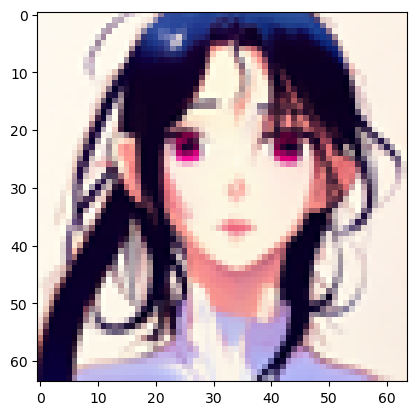

Rotated Image


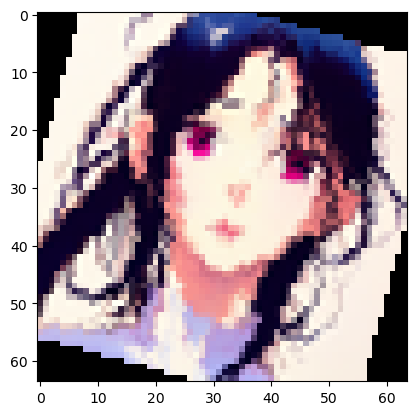

Horizontal Flip Image


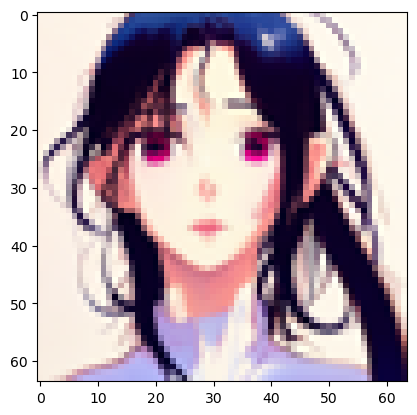

Color Jitter Image


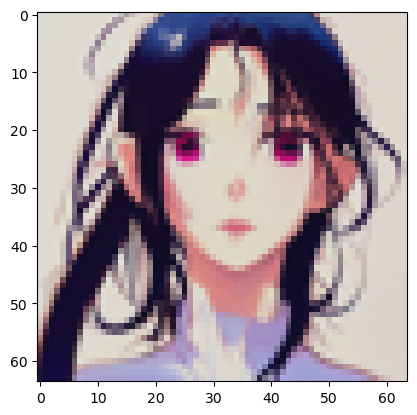

Resized Crop Image


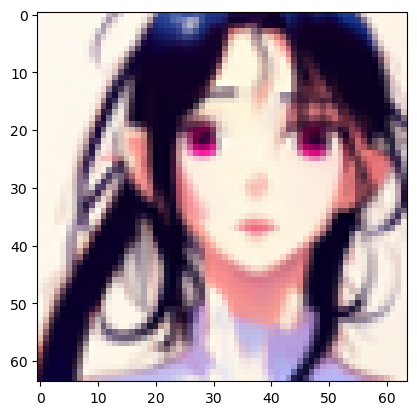

In [15]:
# for more image transforms  https://pytorch.org/vision/stable/transforms.html

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

horizontal_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

rotation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

color_jitter_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor()
])

resized_crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop((64, 64), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

original_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=original_transform)
horizontal_flip_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=horizontal_flip_transform)
rotation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=rotation_transform)
color_jitter_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=color_jitter_transform)
resized_crop_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=resized_crop_transform)

train_dataset = ConcatDataset([original_dataset, horizontal_flip_dataset, rotation_dataset, color_jitter_dataset, resized_crop_dataset])
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)


val_dataset = CustomImageDataset(img_dir=DATA_PATH + "val_images", csv_file=DATA_PATH + "val.csv", transform=original_transform)
test_dataset = TestImageDataset(img_dir=DATA_PATH + "test_images", csv_file=DATA_PATH + "test.csv", transform=original_transform)

val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

# print(len(train_dataset))
# print(len(train_loader))

print("Original Image")
plt.imshow(original_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Rotated Image")
plt.imshow(rotation_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Horizontal Flip Image")
plt.imshow(horizontal_flip_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Color Jitter Image")
plt.imshow(color_jitter_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Resized Crop Image")
plt.imshow(resized_crop_dataset[0][0].permute(1, 2, 0))
plt.show()



Original Image


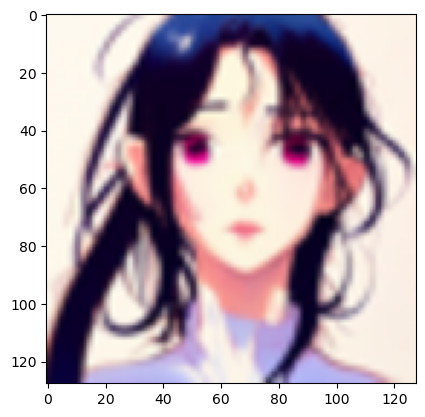

In [12]:
original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=original_transform)

print("Original Image")
plt.imshow(original_dataset[0][0].permute(1, 2, 0))
plt.show()


In [8]:
class DeepNet(nn.Module):
    def __init__(self, num_classes=96):
        super(DeepNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch, you can also use x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [9]:
def save_model(model, optimizer, path):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, path)

def load_model(model, optimizer, path):
    state = torch.load(path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    return model, optimizer

In [10]:
def train_model(train_loader, val_loader, hyperparameters):
    model = DeepNet().to(device)
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    num_epochs = hyperparameters['epochs']

    for epoch in range(num_epochs):
        print("Starting epoch: ", epoch)
        # set the model to train mode
        # enable dropout, batch normalization etc.
        model.train()
        for images, labels in train_loader:
            # loads the images to cuda if available
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute the loss

            optimizer.zero_grad() # reset the gradients because they accumulate by default
            loss.backward() # compute the gradients in the backward pass
            optimizer.step() # update the parameters based on the gradients computed in the backward pass
        print("Validating data...")
        # set the model to evaluation mode
        # disable dropout, batch normalization etc.
        model.eval()
        with torch.no_grad():  #o disable gradient calculation and backpropagation
            val_loss = 0
            correct = 0
            total = 0
            for images, labels in val_loader:
                # loads the images to cuda if available
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # torch.max returns a tuple (values, indices) where indices is the index of the maximum value of a tensor along a dimension
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            val_loss /= len(val_loader)
            scheduler.step(val_loss) # step the scheduler based on the validation loss

            print('Epoch [{}/{}], Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
                  .format(epoch+1, num_epochs, 100 * correct / total, val_loss))    
        if epoch % 10 == 0:
            # torch.save(model.state_dict(), 'model-{}.ckpt'.format(epoch))
            save_model(model, optimizer, f"model_{epoch}.ckpt")
    return model, optimizer

        

In [11]:
def test_model(model, test_loader):
    model.eval()
    predicted_labels = []
    image_ids = []
    with torch.no_grad(): # to disable gradient calculation and backpropagation
        for images, ids in test_loader:
            images = images.to(device)

            outputs = model(images) # forward pass

            _, predicted = torch.max(outputs.data, 1) # get the predicted class with highest probability

            predicted_labels.extend(predicted.tolist())
            image_ids.extend(ids)
    return predicted_labels, image_ids

In [12]:
model, optimizer = train_model(train_loader, val_loader, hyperparameters)
# save_model(model, optimizer,  + "models/model.pth")

Starting epoch:  0


KeyboardInterrupt: 

In [ ]:
predicted_labels, image_ids = test_model(model, test_loader)
df_predictions = pd.DataFrame({
    'Image': image_ids,
    'Class': predicted_labels
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('submission.csv', index=False)

In [ ]:
def train_loaded_model(train_loader, val_loader, model, start_epoch, num_epochs):
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
#     num_epochs = hyperparameters['epochs']

#     for epoch in range(num_epochs):
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print("Starting epoch: ", epoch)
        # set the model to train mode
        # enable dropout, batch normalization etc.
        model.train()
        for images, labels in train_loader:
            # loads the images to cuda if available
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute the loss

            optimizer.zero_grad() # reset the gradients because they accumulate by default
            loss.backward() # compute the gradients in the backward pass
            optimizer.step() # update the parameters based on the gradients computed in the backward pass
        print("Validating data...")
        # set the model to evaluation mode
        # disable dropout, batch normalization etc.
        model.eval()
        with torch.no_grad():  #o disable gradient calculation and backpropagation
            val_loss = 0
            correct = 0
            total = 0
            for images, labels in val_loader:
                # loads the images to cuda if available
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # torch.max returns a tuple (values, indices) where indices is the index of the maximum value of a tensor along a dimension
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            val_loss /= len(val_loader)
            scheduler.step(val_loss) # step the scheduler based on the validation loss

            print('Epoch [{}/{}], Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
                  .format(epoch+1, num_epochs, 100 * correct / total, val_loss))    
        if epoch % 10 == 0:
#             torch.save(model.state_dict(), 'model-{}.ckpt'.format(epoch))
            save_model(model, optimizer, f"model_{epoch}.ckpt")
    return model, optimizer

        